Import Libraries

In [3]:
import pandas as pd
import os
import librosa
import librosa.display
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt
import scipy as sp
import shutil
import dask.array as da
import h5py
import glob
import imageio
from dask.array.image import imread
import dask_image.imread
import dask_image.ndfilters
import dask_image.ndmeasure
from datetime import datetime 
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.layers import Dropout, Input, BatchNormalization
from keras.optimizers import adam_v2
from IPython.display import display
from PIL import Image
#from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from matplotlib import pyplot as plt
from keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
%matplotlib inline

One audio file

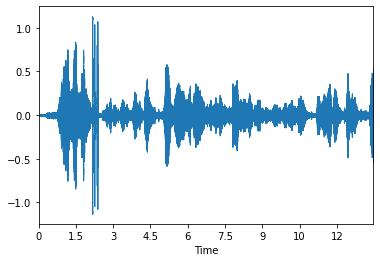

In [4]:
file_name='Audio_labelled_2/fold1/1-1-01-01.wav'
audio_data, sampling_rate = librosa.load(file_name)
librosa.display.waveplot(audio_data,sr=sampling_rate)
#ipd.Audio(file_name)

#Load Audio csv with labels

In [7]:
df = pd.read_csv("Audio_labelled_2/Label1.csv")

In [9]:
df.head(5)

,slice_file_name,fsID,start,end,duration,fold,classID,class
0,1-1.wav,11,0,201.999,201.999,1,1,SV
1,3-1.wav,31,202,216.999,14.999,3,3,NV
2,1-2.wav,12,217,228.999,11.999,1,1,SV
3,3-2.wav,32,229,234.000,5.000,3,3,NV
4,1-3.wav,13,234,378.000,144.000,1,1,SV


No of classes

In [10]:
df["class"].value_counts()

SV    18
NV    10
MV     8
Name: class, dtype: int64

#Data preparation.
The set of audio files provided in this project is small for training machine learning model. So the approach used is to split the audio files into equal 10 seconds each for all files and labelling them into respective target classes. The assumption is all 10 seconds audio files might have the same signature for respective classes. The we extract the melspectrogram from each file and create an image with 192x192 dimensions. This is necessary because we can train the CNN model on images from audio representation which bears high prediction score.

#Function creates an audio image of width 192 and height 192 

Since the training sample are less and I have found out that the training data set is leading to overfitting of the model. We are going to try to add more augmented samples for the underepresented classes which are no voice and multiple voice classes


In [11]:
def wav_to_img(path, height=192, width=192):
    signal, sr = librosa.load(path, res_type='kaiser_fast')
    hl = signal.shape[0]//(width*1.1) 
    spec = librosa.feature.melspectrogram(signal, n_mels=height, hop_length=int(hl))
    img = librosa.amplitude_to_db(spec)**2
    start = (img.shape[1] - width) // 2
    return img[:, start:start+width]

In [ ]:
#!pip install numpy requests nlpaug
#!conda install -c makcedward nlpaug
import nlpaug.augmenter.audio as naa
from nlpaug.util.audio.visualizer import AudioVisualizer

def wav_to_img_augment(path, height=192, width=192 , augment = 0):
    signal, sr = librosa.load(path, res_type='kaiser_fast')
    #augmentations

    if augment == 0: pass
    #Crop Augmenter
    elif augment == 1 :
        aug = naa.CropAug(sampling_rate=sr)
        signal = aug.augment(signal)
    #loudness Augmenter
    elif augment == 2 :
        aug = naa.LoudnessAug()
        signal = aug.augment(signal)
    #Mask Augmenter
    elif augment == 3 :
        aug = naa.MaskAug(sampling_rate=sr, mask_with_noise=False)
        signal = aug.augment(signal)
    #Noise Augmenter
    elif augment == 4 :
        aug = naa.NoiseAug()
        signal = aug.augment(signal)
    #Pitch Augmenter
    elif augment == 5 :
        aug = naa.PitchAug(sampling_rate=sr, factor=(2,3))
        signal = aug.augment(signal)
    #Shift Augmenter
    elif augment == 6 :
        aug = naa.ShiftAug(sampling_rate=sr)
        signal = aug.augment(signal)
    #Speed Augmenter
    elif augment == 7 :
        aug = naa.SpeedAug()
        signal = aug.augment(signal)
    #Normalize Augmenter
    elif augment == 8 :
        aug = naa.NormalizeAug(method='minmax')
        signal = aug.augment(signal)

    hl = signal.shape[0]//(width*1.1) 
    spec = librosa.feature.melspectrogram(signal, n_mels=height, hop_length=int(hl))
    img = librosa.amplitude_to_db(spec)**2
    start = (img.shape[1] - width) // 2
    return img[:, start:start+width]

Process All images in all folders

In [ ]:
def process_audio(in_folder, out_folder):
    os.makedirs(out_folder, exist_ok=True)
    files = glob.glob(in_folder+'*.wav')
    start = len(in_folder)
    for file in files:
        img = wav_to_img(file)
        imageio.imwrite(out_folder + file[start:] + '.jpg',img)

Augment audio files

In [ ]:
import random
def process_audio_augment(in_folder, out_folder):
    os.makedirs(out_folder, exist_ok=True)
    files = glob.glob(in_folder+'*.wav')
    start = len(in_folder)
    #we are going to choose random augumentations
    #a list of posible augmentations
    augments = [a for a in range(9)] # a choice of 9 transformations on each audio file
    
    for file in files:
        choice = random.sample(augments, 6) #just 3 samples to augment the samples by 3 we can try another number
        for c in choice:
            img = wav_to_img_augment(file, augment=c)
            imageio.imwrite(out_folder + file[start:] + str(c) +'.jpg',img)

For single voice class we dont need to augment the data

In [ ]:
process_audio('Audio_labelled_2/fold1/', 'Audio_data/jpg/')

Lossy conversion from float32 to uint8. Range [1.6473290997964796e-07, 4594.83251953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [4.5178880100138485e-05, 3423.510498046875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.19161961467762e-06, 5001.91650390625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [4.485885710892035e-06, 4535.94189453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [9.800381121749524e-06, 4508.1552734375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [4.669665031542536e-06, 4570.81201171875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.9363444891951076e-07, 3075

For No voice and Multivoice classes there is limited data so we are going to augment the data with code from https://github.com/makcedward/nlpaug/blob/master/example/audio_augmenter.ipynb

In [ ]:
process_audio_augment('Audio_labelled_2/fold2/', 'Audio_data/jpg/')
process_audio_augment('Audio_labelled_2/fold3/', 'Audio_data/jpg/')

Lossy conversion from float32 to uint8. Range [1.6119693100336008e-06, 4815.69189453125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.4381683942920063e-06, 4823.498046875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.2225898444739869e-06, 4862.69140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.0942503397236578e-05, 4862.69140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.0942503397236578e-05, 4862.69140625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [1.3708468031836674e-05, 4804.63720703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [2.509665897321156e-08, 1604.831542

Convert audio images to numpy arrays and store them in a local h5 file

In [ ]:
def jpgs_to_h5(source, target, name):
    imread(source + '*.jpg').to_hdf5(target, name)

Display images for the three classes we can see there is significant difference in the three class images. These are audio features collected from the audio files . Mostly class 1 images have a dark color in the whole image. while class 3 images are mostly white as can be seen below. The highlighted difference is what is going to make the model train well on the samples.

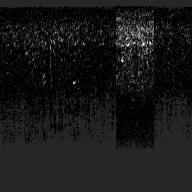

Class 1 1-13-03-04.wav.jpg


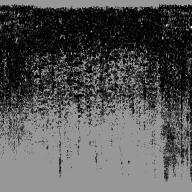

Class 2-2-02.wav5.jpg


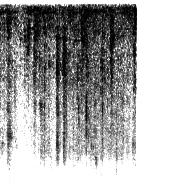

Class 3 3-8-01.wav6.jpg


In [ ]:
path="Audio_data/jpg/2-3-01-05.wav8.jpg"
display(Image.open(path))
print('Class 1 1-13-03-04.wav.jpg')
path="Audio_data/jpg/2-2-02.wav5.jpg"
display(Image.open(path))
print("Class 2-2-02.wav5.jpg")
path="Audio_data/jpg/3-8-01.wav6.jpg"
display(Image.open(path))
print("Class 3 3-8-01.wav6.jpg")

JPGS to h5

https://examples.dask.org/applications/image-processing.html

In [ ]:
jpgs_to_h5('Audio_data/jpg/', 'Audio_h5/data.h5', 'data')

In [ ]:
x = h5py.File('Audio_h5/data.h5')['data']

In [ ]:
x.shape

(410, 192, 192)

In [ ]:
x = da.from_array(x, chunks=10)

In [ ]:
x

,Array,Chunk
Bytes,14.41 MiB,0.98 kiB
Shape,"(410, 192, 192)","(10, 10, 10)"
Count,16401 Tasks,16400 Chunks
Type,uint8,numpy.ndarray


In [ ]:
x[0]

dask.array<getitem, shape=(192, 192), dtype=uint8, chunksize=(10, 10), chunktype=numpy.ndarray>

In [ ]:

df_labels = pd.DataFrame(columns=['file_name', 'class'])
files_jpg = os.listdir("Audio_data/jpg/")
files_jpg.sort(reverse=False)
index=0
for f in files_jpg:
    df_labels.loc[index, 'file_name'] = f
    fold = int(f.split("-")[0])
    if fold == 1:
        df_labels.loc[index, 'class'] = "SV"
    elif fold == 2:
        df_labels.loc[index, 'class'] = "MV"
    elif fold == 3:
        df_labels.loc[index, 'class'] = "NV"
    index+=1

df_labels.head(3)    

,file_name,class
0,1-1-01-01.wav.jpg,SV
1,1-1-01-02.wav.jpg,SV
2,1-1-01-03.wav.jpg,SV


In [ ]:
#no of value counts for current df
df_labels["class"].value_counts()

MV    174
SV    129
NV    107
Name: class, dtype: int64

In [ ]:
y = df_labels.iloc[:, 1]
y = pd.get_dummies(y)
y = y.reindex(sorted(y.columns), axis=1)
y = y.values
print(y[:5])
y = da.from_array(y, chunks=10)
y

[[0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


dask.array<array, shape=(410, 3), dtype=uint8, chunksize=(10, 3), chunktype=numpy.ndarray>

We have a total of 410 training and testing audio images. We are going to split the dataset with 300 audio training set, validation set of 55 samples and 55 testing samples. The dataset will be shuffled before splitting and the numpy array values for the images will be saved to a h5 file with respective 

In [ ]:
data_size = 410
tr_size = 300
va_size = 55
te_size = 55
np.random.seed(42)
shfl = np.random.permutation(data_size)

tr_idx = shfl[:tr_size]
va_idx = shfl[tr_size:tr_size+va_size]
te_idx = shfl[tr_size+va_size:]

x[tr_idx].to_hdf5('Audio_data/x_tr.h5', 'x_tr')
y[tr_idx].to_hdf5('Audio_data/y_tr.h5', 'y_tr')
x[va_idx].to_hdf5('Audio_data/x_va.h5', 'x_va')
y[va_idx].to_hdf5('Audio_data/y_va.h5', 'y_va')
x[te_idx].to_hdf5('Audio_data/x_te.h5', 'x_te')
y[te_idx].to_hdf5('Audio_data/y_te.h5', 'y_te')

In [ ]:
tr_idx.shape

(300,)

In [ ]:
te_idx.shape

(55,)

In [ ]:
va_idx.shape

(55,)

In [ ]:
x_tr = da.from_array(h5py.File('Audio_data/x_tr.h5')['x_tr'], chunks=10)
y_tr = da.from_array(h5py.File('Audio_data/y_tr.h5')['y_tr'], chunks=10)
print(x_tr.shape, y_tr.shape)

x_va = da.from_array(h5py.File('Audio_data/x_va.h5')['x_va'], chunks=10)
y_va = da.from_array(h5py.File('Audio_data/y_va.h5')['y_va'], chunks=10)
print(x_va.shape, y_va.shape)

x_te = da.from_array(h5py.File('Audio_data/x_te.h5')['x_te'], chunks=10)
y_te = da.from_array(h5py.File('Audio_data/y_te.h5')['y_te'], chunks=10)
print(x_te.shape, y_te.shape)

(300, 192, 192) (300, 3)
(55, 192, 192) (55, 3)
(55, 192, 192) (55, 3)


Scale X

In [ ]:
x_tr /= 255.
x_va /= 255.
x_te /= 255.

In [ ]:
x_tr

,Array,Chunk
Bytes,84.38 MiB,7.81 kiB
Shape,"(300, 192, 192)","(10, 10, 10)"
Count,24001 Tasks,12000 Chunks
Type,float64,numpy.ndarray


In [ ]:
x_va

,Array,Chunk
Bytes,15.47 MiB,7.81 kiB
Shape,"(55, 192, 192)","(10, 10, 10)"
Count,4801 Tasks,2400 Chunks
Type,float64,numpy.ndarray


In [ ]:
x_te

,Array,Chunk
Bytes,15.47 MiB,7.81 kiB
Shape,"(55, 192, 192)","(10, 10, 10)"
Count,4801 Tasks,2400 Chunks
Type,float64,numpy.ndarray


#Model

Now that we have the data prepared we create the model which will input samples will have an input dimension of (192, 192) . The output dimension will be three classes.

In [ ]:
in_dim = (192,192,1)
out_dim = 3
i = Input(shape=in_dim)
m = Conv2D(16, (3, 3), activation='relu', padding='same')(i)
m = MaxPooling2D()(m)
m = Conv2D(32, (3, 3), activation='relu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(64, (3, 3), activation='relu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(128, (3, 3), activation='relu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(256, (3, 3), activation='relu', padding='same')(m)
m = MaxPooling2D()(m)
m = Flatten()(m)
m = Dense(512, activation='relu')(m)
m = Dropout(0.5)(m)
o = Dense(out_dim, activation='softmax')(m)

model = Model(inputs=i, outputs=o)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 192, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        18496 

#Model Fitting

We fit the model on the training samples while doing validation and save the check point to the model with the best accuracy on validation set

In [ ]:
num_epochs = 10
checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()
model.compile(loss='categorical_crossentropy', optimizer=adam_v2.Adam(learning_rate=1e-4), metrics=['accuracy'])
history=model.fit(x_tr, y_tr, epochs=num_epochs, verbose=1, batch_size = 32, validation_data=(x_va, y_va) ,callbacks=[checkpointer])
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/10


2021-12-07 20:00:45.457446: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.
2021-12-07 20:00:50.749003: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.


 1/10 [==>...........................] - ETA: 20:16 - loss: 1.1039 - accuracy: 0.3125

2021-12-07 20:00:51.035535: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.
2021-12-07 20:00:53.120705: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.


 2/10 [=====>........................] - ETA: 18s - loss: 1.0969 - accuracy: 0.3125  

2021-12-07 20:00:53.501907: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 75497472 exceeds 10% of free system memory.


10/10 [==============================] - ETA: 0s - loss: 1.0387 - accuracy: 0.3900WARNING:tensorflow:Keras is training/fitting/evaluating on array-like data. Keras may not be optimized for this format, so if your input data format is supported by TensorFlow I/O (https://github.com/tensorflow/io) we recommend using that to load a Dataset instead.

Epoch 00001: val_loss improved from inf to 0.97537, saving model to saved_models/audio_classification.hdf5
10/10 [==============================] - 235s 11s/step - loss: 1.0387 - accuracy: 0.3900 - val_loss: 0.9754 - val_accuracy: 0.3273
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.9038 - accuracy: 0.5900 
Epoch 00002: val_loss improved from 0.97537 to 0.78156, saving model to saved_models/audio_classification.hdf5
10/10 [==============================] - 122s 13s/step - loss: 0.9038 - accuracy: 0.5900 - val_loss: 0.7816 - val_accuracy: 0.7818
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.7587 -

#Testing Accuracy

We are going to evaluate the model on unseen testing data. Here we can see we have a test accuracy of 93.33%. Which we can improve with more training data.

In [ ]:
model.evaluate(x_te, y_te)

2/2 [==============================] - 16s 415ms/step - loss: 0.1829 - accuracy: 0.9273


[0.1828901767730713, 0.9272727370262146]

Prediction Of Audio file

Stream Audio file displaying on a graph

Chunking the audio test file into smaller segments

In [ ]:
from pydub import AudioSegment
from pydub.utils import make_chunks
import numpy as np
audio_test = "Audio_labelled/3-2-1-2-3-1-3.wav"
myaudio = AudioSegment.from_file(audio_test , "wav") 
chunk_length_ms = 10000 # pydub calculates in millisec
chunks = make_chunks(myaudio, chunk_length_ms) #Make chunks of 10 seconds


#Export all of the individual chunks as wav files

for i, chunk in enumerate(chunks):
    chunk_name = "test/audio/chunk{0}.wav".format(i)
    print("exporting", chunk_name)
    chunk.export(chunk_name, format="wav")

    


exporting test/audio/chunk0.wav
exporting test/audio/chunk1.wav
exporting test/audio/chunk2.wav
exporting test/audio/chunk3.wav
exporting test/audio/chunk4.wav
exporting test/audio/chunk5.wav
exporting test/audio/chunk6.wav
exporting test/audio/chunk7.wav
exporting test/audio/chunk8.wav
exporting test/audio/chunk9.wav
exporting test/audio/chunk10.wav
exporting test/audio/chunk11.wav


Classes for truth table

In [ ]:
#Gather all audio chunks for prediction


files_jpg = os.listdir("test/audio/")
files_jpg.sort(reverse=False)

Load A trained saved model incase you dont have time to train one

In [ ]:
from keras.models import load_model
model = load_model('saved_models/audio_classification.hdf5')

Analyse audio test files for Multiple voice , Single voice , No voice and Silence save the features in a dataframe to easily plot on bar chart

In [ ]:
df_bars = pd.DataFrame(columns=['index', 'time', 'class', 'color'])
index = 0
'''
set classes for the final data frame to plot values on bar chart
@param df_bars
@param index
@param time slice
@param classid
@param color
'''
def set_df_values(df_bars, index, time, classid, color):
    df_bars.loc[index, 'index'] = index
    df_bars.loc[index, 'time'] = time
    df_bars.loc[index, 'class'] = classid
    df_bars.loc[index, 'color'] = color


for file in files_jpg:

    path = "test/audio/" + file
    test_image = wav_to_img(path)
    test_image /= 255
    test_image = da.from_array(test_image, chunks=1)

    test_image = test_image.reshape((1,test_image.shape[0], test_image.shape[1]))
    #predict this segm
    pred = model.predict(test_image)
    result = np.where(pred[0] == np.amax(pred[0]))
    result = result[0][0]
    #predict single voice
    if result == 2:
        set_df_values(df_bars, index, 10, "SV", "blue")
       
    #predict multiple voice    
    elif result == 1:
        set_df_values(df_bars, index, 10, "MV", "orange")
    #predict no voice
    elif result == 0:
        set_df_values(df_bars, index, 10, "NV", "green")
    index+=10
    

In [ ]:
path = "test/audio/" + "chunk2.wav"
test_image = wav_to_img(path)
test_image /= 255
test_image = da.from_array(test_image, chunks=1)

test_image = test_image.reshape((1,test_image.shape[0], test_image.shape[1]))
pred = model.predict(test_image)
pred
result = np.where(pred[0] == np.amax(pred[0]))
result[0][0]

array([[1.4504309e-07, 9.9999988e-01, 5.8927421e-19]], dtype=float32)

Display the output on graph

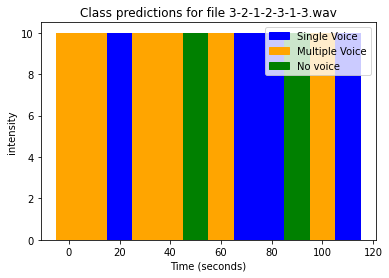

In [ ]:
xx=df_bars.iloc[:, 0].values.tolist()
yy =np.array(df_bars.iloc[:, 1].values.tolist())
plt.bar(xx,yy,width=10, color=df_bars.iloc[:, 3].values.tolist())
plt.xlabel('Time (seconds)')
plt.ylabel("intensity")
plt.title('Class predictions for file ' + audio_test.split("/")[-1])

colors = {'Single Voice':'blue', 'Multiple Voice':'orange', 'No voice':'green'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.show()

#References
https://stackoverflow.com/questions/35169706/audio-feature-for-deep-learning

https://towardsdatascience.com/10-minutes-to-building-a-cnn-binary-image-classifier-in-tensorflow-4e216b2034aa

https://github.com/pietz/language-recognition/blob/master/data/train_list.csv

https://examples.dask.org/applications/image-processing.html

https://librosa.org/doc/main/generated/librosa.feature.spectral_centroid.html

https://stats.stackexchange.com/questions/426818/do-i-need-3-rgb-channels-for-a-spectrogram-cnn

https://towardsdatascience.com/the-4-convolutional-neural-network-models-that-can-classify-your-fashion-images-9fe7f3e5399d

https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab

https://examples.dask.org/applications/image-processing.html